In [16]:
import os
import glob
import time
import math
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from PIL import ImageFilter

from scipy import ndimage as ndi
from skimage import feature

from sklearn import preprocessing as preprocess
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import cv2

from tqdm import tqdm
'''
Load and return a single image as a 100x100x3 array
'''
# Open Image
im1 = Image.open("C:/Users/tdtra/Google Drive/13 SPRING 2019/EEL4930/project-trm/TRM_Pics/2019_sp_ml_train_data/k/119.jpg")
im2 = Image.open("C:/Users/tdtra/Google Drive/13 SPRING 2019/EEL4930/project-trm/TRM_Pics/2019_sp_ml_train_data/d/2.jpg")
im3 = Image.open("C:/Users/tdtra/Google Drive/13 SPRING 2019/EEL4930/project-trm/TRM_Pics/2019_sp_ml_train_data/p/96.jpg")
im4 = Image.open("C:/Users/tdtra/Google Drive/13 SPRING 2019/EEL4930/project-trm/TRM_Pics/2019_sp_ml_train_data/s/38.jpg")
im5 = Image.open("C:/Users/tdtra/Google Drive/13 SPRING 2019/EEL4930/project-trm/TRM_Pics/2019_sp_ml_train_data/m/206.jpg")

def hsv_rgb(im):
    
    im = im.filter(ImageFilter.BoxBlur(3))

    img_rgb = list(im.getdata()) # a set of 3 values(R, G, B)
    img_hsv = list(im.convert('HSV').getdata())

    # Convert lists to arrays
    rgb_image_arr = np.asarray(img_rgb, dtype=np.uint8)
    hsv_image_arr = np.asarray(img_hsv, dtype=np.uint8)

    # Convert data arrays to [(num_images)x100x100x3]
    rgb_image_arr = np.reshape(rgb_image_arr, (100, 100, 3))
    hsv_image_arr = np.reshape(hsv_image_arr, (100, 100, 3))
    
    return (rgb_image_arr, hsv_image_arr)

rgb_image_arr_1, hsv_image_arr_1 = hsv_rgb(im1)
rgb_image_arr_2, hsv_image_arr_2 = hsv_rgb(im2)
rgb_image_arr_3, hsv_image_arr_3 = hsv_rgb(im3)
rgb_image_arr_4, hsv_image_arr_4 = hsv_rgb(im4)
rgb_image_arr_5, hsv_image_arr_5 = hsv_rgb(im5)

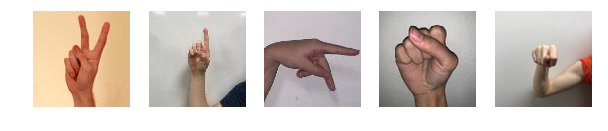

In [26]:
plt.figure(figsize=(10, 10)) 

plt.subplot(251)
imgplot = plt.imshow(im1)
plt.axis('off')
plt.subplot(252)
imgplot = plt.imshow(im2)
plt.axis('off')
plt.subplot(253)
imgplot = plt.imshow(im3)
plt.axis('off')
plt.subplot(254)
imgplot = plt.imshow(im4)
plt.axis('off')
plt.subplot(255)
imgplot = plt.imshow(im5)
plt.axis('off')

plt.show()

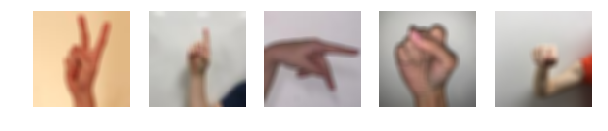

In [27]:
plt.figure(figsize=(10, 10)) 

plt.subplot(251)
imgplot = plt.imshow(rgb_image_arr_1)
plt.axis('off')
plt.subplot(252)
imgplot = plt.imshow(rgb_image_arr_2)
plt.axis('off')
plt.subplot(253)
imgplot = plt.imshow(rgb_image_arr_3)
plt.axis('off')
plt.subplot(254)
imgplot = plt.imshow(rgb_image_arr_4)
plt.axis('off')
plt.subplot(255)
imgplot = plt.imshow(rgb_image_arr_5)
plt.axis('off')


plt.show()

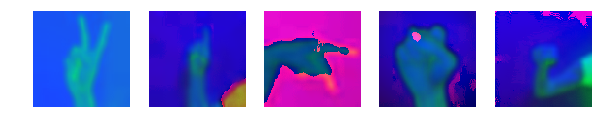

In [18]:
plt.figure(figsize=(10, 10)) 

plt.subplot(251)
imgplot = plt.imshow(hsv_image_arr_1)
plt.axis('off')
plt.subplot(252)
imgplot = plt.imshow(hsv_image_arr_2)
plt.axis('off')
plt.subplot(253)
imgplot = plt.imshow(hsv_image_arr_3)
plt.axis('off')
plt.subplot(254)
imgplot = plt.imshow(hsv_image_arr_4)
plt.axis('off')
plt.subplot(255)
imgplot = plt.imshow(hsv_image_arr_5)
plt.axis('off')

plt.show()

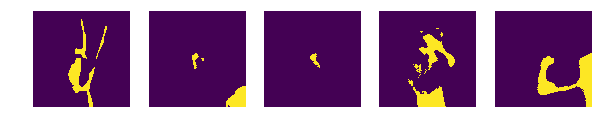

In [19]:
'''
Preprocess an image for feature extraction and classification
'''
#######################################################################

def masking(hsv_image_arr):

    # Detect hand and crop edges to tightly enclose it
    im_hue = hsv_image_arr[:,:,1]

    crop_img = im_hue[45:55, 45:55]

    average_hand = np.mean(crop_img, dtype=np.float64)

    h_mask = (im_hue >= average_hand) & (im_hue <= 255)
    
    return (h_mask, im_hue, average_hand)

h_mask_1, im_hue_1, average_hand_1 = masking(hsv_image_arr_1)
h_mask_2, im_hue_2, average_hand_2 = masking(hsv_image_arr_2)
h_mask_3, im_hue_3, average_hand_3 = masking(hsv_image_arr_3)
h_mask_4, im_hue_4, average_hand_4 = masking(hsv_image_arr_4)
h_mask_5, im_hue_5, average_hand_5 = masking(hsv_image_arr_5)

plt.figure(figsize=(10, 10)) 

plt.subplot(251)
imgplot = plt.imshow(h_mask_1)
plt.axis('off')
plt.subplot(252)
imgplot = plt.imshow(h_mask_2)
plt.axis('off')
plt.subplot(253)
imgplot = plt.imshow(h_mask_3)
plt.axis('off')
plt.subplot(254)
imgplot = plt.imshow(h_mask_4)
plt.axis('off')
plt.subplot(255)
imgplot = plt.imshow(h_mask_5)
plt.axis('off')

plt.show()

In [32]:
def cropping(h_mask, im_hue, average_hand):
    x = 45
    y = 55
    h = 0

    row_sum1 = 0
    row_sum2 = 0

    col_sum1 = 0
    col_sum2 = 0

    crop_img = h_mask[x-h:y+h, x-h:y+h]


    while(1):
        i = 0
        for i in range( len(crop_img) - 1):
            if (crop_img[0, i] == False):
                row_sum1 += 1
            elif (crop_img[len(crop_img)-1, i] == False):
                row_sum2 += 1
            elif (crop_img[i, 0] == False):
                col_sum1 += 1
            elif (crop_img[i, len(crop_img)-1] == False):
                col_sum2 += 1

            i+=1

        average = (row_sum1 + row_sum2 + col_sum1 + col_sum2) / (4 * (i-1))
        average_com = (4 * (i-1))

        h += 5
        crop_img = h_mask[x-h:y+h, x-h:y+h]

        #print(average)
        #print(average_com/average_hand)
        if average_com/average_hand >= 2.0:
            break
        elif h == 45:
            break
        else: 
            average     = 0
            row_sum1    = 0
            row_sum2    = 0
            col_sum1    = 0
            col_sum2    = 0

    crop_img = im_hue[x-h:y+h, x-h:y+h]

    resize_img = cv2.resize(crop_img,(100,100))
    
    return resize_img

resize_img_1 = cropping(h_mask_1, im_hue_1, average_hand_1)
resize_img_2 = cropping(h_mask_2, im_hue_2, average_hand_2)
resize_img_3 = cropping(h_mask_3, im_hue_3, average_hand_3)
resize_img_4 = cropping(h_mask_4, im_hue_4, average_hand_4)
resize_img_5 = cropping(h_mask_5, im_hue_5, average_hand_5)

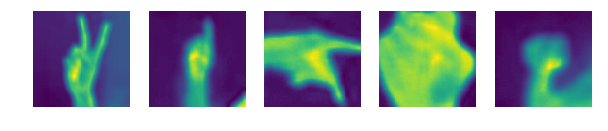

In [33]:
plt.figure(figsize=(10, 10)) 

plt.subplot(251)
imgplot = plt.imshow(resize_img_1)
plt.axis('off')
plt.subplot(252)
imgplot = plt.imshow(resize_img_2)
plt.axis('off')
plt.subplot(253)
imgplot = plt.imshow(resize_img_3)
plt.axis('off')
plt.subplot(254)
imgplot = plt.imshow(resize_img_4)
plt.axis('off')
plt.subplot(255)
imgplot = plt.imshow(resize_img_5)
plt.axis('off')

plt.show()